In [1]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import mne
%matplotlib inline

subject = 'A0149'
path = '/Volumes/teon-backup/Experiments/E-MEG/data/%s/mne' % subject
plot_path = '/Applications/packages/E-MEG/output/results/%s/meg' % subject
raw_file = '%s_OLDT_calm_lp40' % subject + '-raw.fif'

In [2]:
raw = mne.io.Raw(op.join(path, raw_file), verbose=False, preload=False)
evts = mne.read_events(op.join(path, '%s_OLDT-eve.txt') % subject)
event_id = {'nonword': 1, 'word': 2}

epochs = mne.Epochs(raw, evts, event_id, tmin=-.1, tmax=.5, baseline=None,
                    reject={'mag': 3e-12}, preload=True, decim=4,
                    verbose=False)
epochs_list = [epochs[k] for k in ('nonword', 'word')]
mne.epochs.equalize_epoch_counts(epochs_list)
evoked = epochs_list[1].average() - epochs_list[0].average()

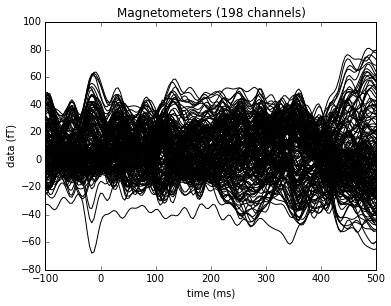

In [3]:
evoked.plot();

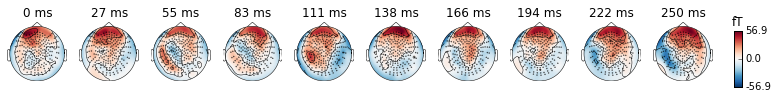

In [4]:
evoked.plot_topomap(np.linspace(0, .25, 10));

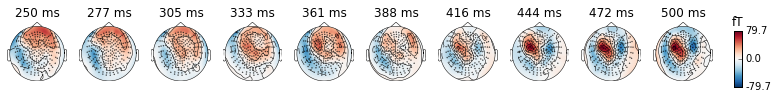

In [5]:
evoked.plot_topomap(np.linspace(.25, .50, 10)); 

In [6]:
n_times = len(epochs.times)
data_picks = mne.pick_types(epochs.info, meg=True, exclude='bads')
X = [e.get_data()[:, data_picks, :] for e in epochs_list]
y = [k * np.ones(len(this_X)) for k, this_X in enumerate(X)]
X = np.concatenate(X).astype('float32')
y = np.concatenate(y).astype('float32')

from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score, ShuffleSplit

clf = SVC(C=1, kernel='linear')
# Define a monte-carlo cross-validation generator (reduce variance):
cv = ShuffleSplit(len(X), 10, test_size=0.2)

scores = np.empty(n_times, np.float32)
std_scores = np.empty(n_times, np.float32)

for t in xrange(n_times):
    Xt = X[:, :, t]
    # Standardize features
    Xt -= Xt.mean(axis=0)
    Xt /= Xt.std(axis=0)
    # Run cross-validation
    # Note : for sklearn the Xt matrix should be 2d (n_samples x n_features)
    scores_t = cross_val_score(clf, Xt, y, cv=cv, n_jobs=1)
    scores[t] = scores_t.mean()
    std_scores[t] = scores_t.std()

times = 1e3 * epochs.times
scores *= 100  # make it percentage
std_scores *= 100

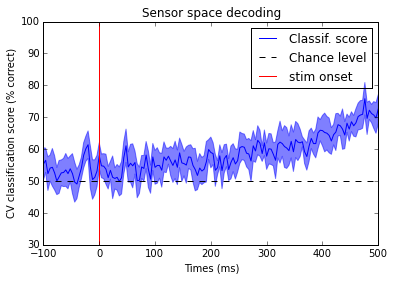

In [7]:
plt.close('all')
plt.plot(times, scores, label="Classif. score")
plt.axhline(50, color='k', linestyle='--', label="Chance level")
plt.axvline(0, color='r', label='stim onset')
plt.legend()
hyp_limits = (scores - std_scores, scores + std_scores)
plt.fill_between(times, hyp_limits[0], y2=hyp_limits[1], color='b', alpha=0.5)
plt.xlabel('Times (ms)')
plt.ylabel('CV classification score (% correct)')
plt.ylim([30, 100])
plt.title('Sensor space decoding')